In [1]:
# script to merge 2009 and 2016 rail data into a combined panel

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as smf
import linearmodels as lm

from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import compare
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', 500)


%matplotlib inline

In [2]:
df = pd.read_csv('D:/TNC-Demand-Model/Outputs/Chi_Estimation_File.csv',usecols = ['ORIGIN','DESTINATION','MONTH','YEAR','TRIPS_SUPPRESSED','TRIPS_UNSUPPRESSED','TRAVEL_TIME_MINUTES','DISTANCE','FARE','TOTAL_POP','TOTAL_HHLDS','HHLDS_MEAN_INCOME','HHLDS_0_VEH','AVG_VEH_PER_HHLD','TOTAL_POP_DESTINATION','MEDIAN_AGE_DESTINATION','MEDIAN_AGE','TOTAL_HHLDS_DESTINATION','HHLDS_MEAN_INCOME_DESTINATION','HHLDS_0_VEH_DESTINATION','AVG_VEH_PER_HHLD_DESTINATION','travel_time','PRIVATE_TAX','SHARED_TAX','TOTAL_JOBS_ORIGIN','TOTAL_JOBS_DESTINATION','TOTAL_WORKERS_ORIGIN','TOTAL_WORKERS_DESTINATION'])
#df = pd.read_csv('D:/TNC-Demand-Model/Outputs/Chi_Estimation_File.csv')

In [14]:
df.columns

Index(['YEAR', 'MONTH', 'ORIGIN', 'DESTINATION', 'TRIPS_SUPPRESSED',
       'TRIPS_UNSUPPRESSED', 'TRAVEL_TIME_MINUTES', 'DISTANCE', 'FARE',
       'TOTAL_POP', 'MEDIAN_AGE', 'TOTAL_HHLDS', 'HHLDS_MEAN_INCOME',
       'HHLDS_0_VEH', 'AVG_VEH_PER_HHLD', 'TOTAL_POP_DESTINATION',
       'MEDIAN_AGE_DESTINATION', 'TOTAL_HHLDS_DESTINATION',
       'HHLDS_MEAN_INCOME_DESTINATION', 'HHLDS_0_VEH_DESTINATION',
       'AVG_VEH_PER_HHLD_DESTINATION', 'travel_time', 'PRIVATE_TAX',
       'SHARED_TAX', 'TOTAL_JOBS_ORIGIN', 'TOTAL_JOBS_DESTINATION',
       'TOTAL_WORKERS_ORIGIN', 'TOTAL_WORKERS_DESTINATION', 'TOTAL_WORKERS_OD',
       'TOTAL_JOBS_OD', 'HHLDS_MEAN_INCOME_OD', 'AVG_VEH_PER_HHLD_OD',
       'HHLDS_0_VEH_OD', 'MEDIAN_AGE_OD', 'TRIPS_ALL', 'TOTAL_POP_OD'],
      dtype='object')

In [3]:
for col in df.columns:
    print(col)

Unnamed: 0
YEAR
MONTH
ORIGIN
DESTINATION
Unnamed: 0_RAC_ORIGIN
Unnamed: 0_x
TOD
Pickup Census Tract
Dropoff Census Tract
DAY_PRIVATE
Trip Seconds_PRIVATE
Trip Miles_PRIVATE
Fare_PRIVATE
Tip_PRIVATE
Additional Charges_PRIVATE
Trip Total_PRIVATE
TRIPS_PRIVATE
Trips Pooled_PRIVATE
TRAVEL_TIME_MINUTES_PRIVATE
SPEED_PRIVATE
DAY_SHARED
Trip Seconds_SHARED
Trip Miles_SHARED
Fare_SHARED
Tip_SHARED
Additional Charges_SHARED
Trip Total_SHARED
TRIPS_SHARED
Trips Pooled_SHARED
TRAVEL_TIME_MINUTES_SHARED
SPEED_SHARED
Unnamed: 0_y
GEOID_PICKUP
GEOID_DROPOFF
DAY
Pickup Community Area
Dropoff Community Area
TRIPS_SHARED_UNSUPPRESSED
TRIPS_PRIVATE_UNSUPPRESSED
TRIPS_PRIVATE_SUPPRESSED
TRIPS_SHARED_SUPPRESSED
TRAVEL_TIME_MINUTES_UNSUPPRESSED
TRAVEL_TIME_MINUTES_SUPPRESSED
DISTANCE_UNSUPPRESSED
DISTANCE_SUPPRESSED
FARE_UNSUPPRESSED
FARE_SUPPRESSED
TIP_UNSUPPRESSED
TIP_SUPPRESSED
TAX_AND_SURGE_UNSUPPRESSED
TAX_AND_SURGE_SUPPRESSED
TOTAL_COST_UNSUPPRESSED
TOTAL_COST_SUPPRESSED
TRIPS_POOLED_UNSUPPRESSED
TRI

In [6]:
len(df)

10265616

In [8]:
df = df.drop(['Unnamed: 0','Unnamed: 0_RAC_ORIGIN','Unnamed: 0_x','TOD','DAY_PRIVATE','DAY_SHARED','Unnamed: 0_y','DAY','Unnamed: 0_RAC_DESTINATION','Unnamed: 0_WAC_ORIGIN','Unnamed: 0_WAC_DESTINATION','Unnamed: 0.1'], axis = 1)

In [9]:
for col in df.columns:
    print(col)

YEAR
MONTH
ORIGIN
DESTINATION
Pickup Census Tract
Dropoff Census Tract
Trip Seconds_PRIVATE
Trip Miles_PRIVATE
Fare_PRIVATE
Tip_PRIVATE
Additional Charges_PRIVATE
Trip Total_PRIVATE
TRIPS_PRIVATE
Trips Pooled_PRIVATE
TRAVEL_TIME_MINUTES_PRIVATE
SPEED_PRIVATE
Trip Seconds_SHARED
Trip Miles_SHARED
Fare_SHARED
Tip_SHARED
Additional Charges_SHARED
Trip Total_SHARED
TRIPS_SHARED
Trips Pooled_SHARED
TRAVEL_TIME_MINUTES_SHARED
SPEED_SHARED
GEOID_PICKUP
GEOID_DROPOFF
Pickup Community Area
Dropoff Community Area
TRIPS_SHARED_UNSUPPRESSED
TRIPS_PRIVATE_UNSUPPRESSED
TRIPS_PRIVATE_SUPPRESSED
TRIPS_SHARED_SUPPRESSED
TRAVEL_TIME_MINUTES_UNSUPPRESSED
TRAVEL_TIME_MINUTES_SUPPRESSED
DISTANCE_UNSUPPRESSED
DISTANCE_SUPPRESSED
FARE_UNSUPPRESSED
FARE_SUPPRESSED
TIP_UNSUPPRESSED
TIP_SUPPRESSED
TAX_AND_SURGE_UNSUPPRESSED
TAX_AND_SURGE_SUPPRESSED
TOTAL_COST_UNSUPPRESSED
TOTAL_COST_SUPPRESSED
TRIPS_POOLED_UNSUPPRESSED
TRIPS_POOLED_SUPPRESSED
TRIPS_SUPPRESSED
TRIPS_UNSUPPRESSED
TRIPS_ALL
TRAVEL_TIME_MINUTES
DIS

# Create some variables of interest

In [3]:
df['TOTAL_WORKERS_OD'] = df.TOTAL_WORKERS_ORIGIN + df.TOTAL_WORKERS_DESTINATION

In [4]:
df['TOTAL_JOBS_OD'] = df.TOTAL_JOBS_ORIGIN + df.TOTAL_JOBS_DESTINATION

In [5]:
df['HHLDS_MEAN_INCOME_OD'] = (df.HHLDS_MEAN_INCOME + df.HHLDS_MEAN_INCOME_DESTINATION)/2
df['AVG_VEH_PER_HHLD_OD'] = (df.AVG_VEH_PER_HHLD + df.AVG_VEH_PER_HHLD_DESTINATION)/2
df['HHLDS_0_VEH_OD'] = (df.HHLDS_0_VEH + df.HHLDS_0_VEH_DESTINATION)/2
df['MEDIAN_AGE_OD'] = (df.MEDIAN_AGE + df.MEDIAN_AGE_DESTINATION)/2


In [51]:
df['TRIPS_SUPPRESSED'] = df['TRIPS_SUPPRESSED'].fillna(0)
df['TRIPS_UNSUPPRESSED'] = df['TRIPS_UNSUPPRESSED'].fillna(0)

In [52]:
df['TRIPS_ALL'] = df['TRIPS_SUPPRESSED']+df['TRIPS_UNSUPPRESSED']

In [7]:
df['TOTAL_POP_OD'] = df.TOTAL_POP + df.TOTAL_POP_DESTINATION

In [53]:
df['TRIPS_ALL_EXP'] = np.exp(df['TRIPS_ALL'])
df['TRIPS_ALL_LOG'] = np.log(df['TRIPS_ALL']+1)

C:\Users\transportlab\AppData\Roaming\Python\Python36\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Format as panel data for modeling

In [8]:
df['ENTITY'] = df['ORIGIN'].astype(str) + '_' + df['DESTINATION'].astype(str)
df['TIME'] = df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str)
df['TIME'] =  pd.to_datetime(df['TIME'])

In [10]:
df['TIME'].head()

0   2018-11-01
1   2018-11-01
2   2018-11-01
3   2018-11-01
4   2018-11-01
Name: TIME, dtype: datetime64[ns]

In [9]:
df = df.set_index(['ENTITY', 'TIME'])

In [12]:
df = df.sort_index()

In [13]:
#start with pooled OLS and untransformed data
#use all trips as dependent variable and only test tax variables at first

mod = PooledOLS.from_formula("TRIPS_ALL \
                       ~ SHARED_TAX \
                       + PRIVATE_TAX",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:              TRIPS_ALL   R-squared:                        0.0196
Estimator:                  PooledOLS   R-squared (Between):              0.0209
No. Observations:            10265616   R-squared (Within):              -0.0270
Date:                Fri, Jul 09 2021   R-squared (Overall):              0.0196
Time:                        15:44:36   Log-likelihood                -2.965e+07
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.026e+05
Entities:                      641601   P-value                           0.0000
Avg Obs:                       16.000   Distribution:              F(2,10265614)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):          1.026e+05
                            

In [16]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_ALL \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + SHARED_TAX \
                       + HHLDS_MEAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

C:\Users\transportlab\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PooledOLS Estimation Summary                          
Dep. Variable:              TRIPS_ALL   R-squared:                        0.1825
Estimator:                  PooledOLS   R-squared (Between):              0.1614
No. Observations:             1366585   R-squared (Within):              -0.0277
Date:                Fri, Jul 09 2021   R-squared (Overall):              0.1825
Time:                        15:45:59   Log-likelihood                 -5.06e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.814e+04
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:               F(8,1366577)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          3.814e+04
                            

In [17]:
df['AIRPORT_FLAGGER'] = np.where(df['ORIGIN'].isin([17031980000,17031980100,17031835200,17031770602]), 1, 0)

In [ ]:
df

In [18]:
df['AIRPORT_FLAGGER2'] = np.where(df['DESTINATION'].isin([17031980000,17031980100,17031835200,17031770602]), 1, 0)

In [19]:
df['AIRPORT_FLAGGER'] = df['AIRPORT_FLAGGER'] + df['AIRPORT_FLAGGER2']

In [20]:
df['AIRPORT_FLAGGER'] = np.where(df['AIRPORT_FLAGGER'] == 2, 1, df['AIRPORT_FLAGGER'])

In [54]:
len(df[df['AIRPORT_FLAGGER'] == 1])

102272

In [21]:
df['TOURIST_SPOT_FLAGGER'] = np.where(df['ORIGIN'].isin([17031081402,17031841000]), 1 , 0)

In [22]:
df['TOURIST_SPOT_FLAGGER2'] = np.where(df['DESTINATION'].isin([17031081402,17031841000]), 1 , 0)

In [23]:
df['TOURIST_SPOT_FLAGGER'] = df['TOURIST_SPOT_FLAGGER'] + df['TOURIST_SPOT_FLAGGER2']

In [24]:
df['TOURIST_SPOT_FLAGGER'] = np.where(df['TOURIST_SPOT_FLAGGER'] == 2, 1, df['TOURIST_SPOT_FLAGGER'])

In [25]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_ALL \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + SHARED_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + MEDIAN_AGE \
                       + AIRPORT_FLAGGER \
                       + TOURIST_SPOT_FLAGGER \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

PatsyError: Error evaluating factor: NameError: name 'HHLDS_MEDIAN_INCOME_OD' is not defined
    0 + TRAVEL_TIME_MINUTES + TOTAL_POP_OD + FARE + PRIVATE_TAX + SHARED_TAX + HHLDS_MEDIAN_INCOME_OD + HHLDS_0_VEH_OD + MEDIAN_AGE + AIRPORT_FLAGGER + TOURIST_SPOT_FLAGGER + travel_time
                                                                               ^^^^^^^^^^^^^^^^^^^^^^

In [27]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_ALL \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + SHARED_TAX \
                       + HHLDS_MEAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + MEDIAN_AGE \
                       + AIRPORT_FLAGGER \
                       + TOURIST_SPOT_FLAGGER \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

C:\Users\transportlab\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PooledOLS Estimation Summary                          
Dep. Variable:              TRIPS_ALL   R-squared:                        0.1840
Estimator:                  PooledOLS   R-squared (Between):              0.1604
No. Observations:             1366585   R-squared (Within):              -0.0277
Date:                Fri, Jul 09 2021   R-squared (Overall):              0.1840
Time:                        15:51:20   Log-likelihood                -5.059e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.801e+04
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:              F(11,1366574)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          2.801e+04
                            

In [74]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_PRIVATE \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + MEDIAN_AGE \
                       + AIRPORT_FLAGGER \
                       + TOURIST_SPOT_FLAGGER \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:              TRIPS_ALL   R-squared:                        0.1836
Estimator:                  PooledOLS   R-squared (Between):              0.1607
No. Observations:             1366585   R-squared (Within):              -0.0218
Date:                Wed, Jul 07 2021   R-squared (Overall):              0.1836
Time:                        22:53:33   Log-likelihood                -5.059e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.073e+04
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:              F(10,1366575)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          3.073e+04
                            

In [29]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_PRIVATE \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + HHLDS_MEAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + MEDIAN_AGE \
                       + AIRPORT_FLAGGER \
                       + TOURIST_SPOT_FLAGGER \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:          TRIPS_PRIVATE   R-squared:                        0.1380
Estimator:                  PooledOLS   R-squared (Between):              0.0855
No. Observations:             1366585   R-squared (Within):              -0.0117
Date:                Fri, Jul 09 2021   R-squared (Overall):              0.1380
Time:                        15:59:00   Log-likelihood                -4.919e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.188e+04
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:              F(10,1366575)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          2.188e+04
                            

In [30]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_SHARED \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + SHARED_TAX \
                       + HHLDS_MEAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + MEDIAN_AGE \
                       + AIRPORT_FLAGGER \
                       + TOURIST_SPOT_FLAGGER \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:           TRIPS_SHARED   R-squared:                        0.9826
Estimator:                  PooledOLS   R-squared (Between):              0.9815
No. Observations:             1366585   R-squared (Within):           -8.114e+27
Date:                Fri, Jul 09 2021   R-squared (Overall):              0.9826
Time:                        16:00:55   Log-likelihood                -1.915e+07
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   7.708e+06
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:              F(10,1366575)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          7.708e+06
                            

In [38]:
df['TRIPS_PRIVATE'] = df['TRIPS_PRIVATE'].fillna(0)

df['TRIPS_SHARED'] = df['TRIPS_SHARED'].fillna(0)


In [43]:
df.TRIPS_PRIVATE.value_counts()

0.000000    7792695
1.000000        910
2.000000          2
1.249954          1
1.053765          1
             ...   
1.003780          1
1.002479          1
1.118387          1
1.004945          1
1.667912          1
Name: TRIPS_PRIVATE, Length: 2472012, dtype: int64

In [44]:

mod = PanelOLS.from_formula("TRIPS_PRIVATE \
                       ~ TOTAL_POP_OD \
                       + TOTAL_JOBS_OD \
                       + PRIVATE_TAX \
                       + HHLDS_MEAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time \
                       + EntityEffects ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          TRIPS_PRIVATE   R-squared:                        0.0045
Estimator:                   PanelOLS   R-squared (Between):             -0.3692
No. Observations:            10188864   R-squared (Within):               0.0045
Date:                Fri, Jul 09 2021   R-squared (Overall):             -0.3616
Time:                        16:24:48   Log-likelihood                -7.399e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7153.1
Entities:                      636804   P-value                           0.0000
Avg Obs:                       16.000   Distribution:               F(6,9552054)
Min Obs:                       16.000                                           
Max Obs:                       16.000   F-statistic (robust):             7153.1
                            

In [41]:

mod = PanelOLS.from_formula("TRIPS_SHARED \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + TOTAL_JOBS_OD \
                       + SHARED_TAX \
                       + HHLDS_MEAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time \
                       + EntityEffects ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:           TRIPS_SHARED   R-squared:                        0.0000
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:             1366585   R-squared (Within):               0.0000
Date:                Fri, Jul 09 2021   R-squared (Overall):              0.0000
Time:                        16:20:13   Log-likelihood                 2.769e+07
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0000
Entities:                      197846   P-value                           1.0000
Avg Obs:                       6.9073   Distribution:               F(7,1168732)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          3.501e-27
                            

In [75]:
#Estimate the Log-Log Accessibility Model

mod = PooledOLS.from_formula("TRIPS_ALL \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + SHARED_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + MEDIAN_AGE \
                       + AIRPORT_FLAGGER \
                       + TOURIST_SPOT_FLAGGER \
                       + travel_time ",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:              TRIPS_ALL   R-squared:                        0.1839
Estimator:                  PooledOLS   R-squared (Between):              0.1605
No. Observations:             1366585   R-squared (Within):              -0.0207
Date:                Wed, Jul 07 2021   R-squared (Overall):              0.1839
Time:                        22:54:16   Log-likelihood                -5.059e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.079e+04
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:              F(10,1366575)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):          3.079e+04
                            

In [41]:
#Estimate the Log-Log Accessibility Model

mod = PanelOLS.from_formula("TRIPS_ALL_LOG \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + SHARED_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + HHLDS_0_VEH_OD \
                       + travel_time \
                       + EntityEffects",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          TRIPS_ALL_LOG   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):              0.1097
No. Observations:             1366585   R-squared (Within):               0.0017
Date:                Wed, Jul 07 2021   R-squared (Overall):              0.1073
Time:                        22:30:33   Log-likelihood                 1.065e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      247.20
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:               F(8,1168731)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             247.20
                            

In [27]:
#Estimate the Log-Log Accessibility Model

mod = PanelOLS.from_formula("TRIPS_ALL \
                       ~ TRAVEL_TIME_MINUTES \
                       + TOTAL_POP_OD \
                       + FARE \
                       + PRIVATE_TAX \
                       + SHARED_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + AVG_VEH_PER_HHLD_OD \
                       + travel_time \
                       + EntityEffects",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

C:\Users\transportlab\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:              TRIPS_ALL   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):              0.0881
No. Observations:             1366585   R-squared (Within):               0.0016
Date:                Wed, Jul 07 2021   R-squared (Overall):              0.0706
Time:                        21:59:49   Log-likelihood                -2.182e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      235.14
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:               F(8,1168731)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             235.14
                            

In [17]:
#Estimate the Log-Log Accessibility Model

mod = PanelOLS.from_formula("TRIPS_ALL \
                       ~ TOTAL_JOBS_OD \
                       + TRAVEL_TIME_MINUTES \
                       + PRIVATE_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + AVG_VEH_PER_HHLD_OD \
                       + EntityEffects",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              TRIPS_ALL   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):             -0.1887
No. Observations:             1366585   R-squared (Within):               0.0014
Date:                Wed, Jul 07 2021   R-squared (Overall):             -0.1764
Time:                        21:52:06   Log-likelihood                -2.182e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      339.41
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:               F(5,1168734)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             339.41
                            

In [18]:
#Estimate the Log-Log Accessibility Model

mod = PanelOLS.from_formula("TRIPS_ALL \
                       ~ TOTAL_JOBS_OD \
                       + TRAVEL_TIME_MINUTES \
                       + SHARED_TAX \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + AVG_VEH_PER_HHLD_OD \
                       + EntityEffects",
             data = df)

panel_ols_res = mod.fit()
print(panel_ols_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              TRIPS_ALL   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):             -0.2106
No. Observations:             1366585   R-squared (Within):               0.0015
Date:                Wed, Jul 07 2021   R-squared (Overall):             -0.1897
Time:                        21:52:42   Log-likelihood                -2.182e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      362.56
Entities:                      197846   P-value                           0.0000
Avg Obs:                       6.9073   Distribution:               F(5,1168734)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             362.56
                            

In [26]:
len(df)

10265616

In [19]:
df.TRIPS_ALL.value_counts(dropna= False)

NaN         8869858
2.021368          1
2.310435          1
2.048882          1
5.235959          1
             ...   
2.158126          1
2.027145          1
2.011408          1
3.884425          1
2.010577          1
Name: TRIPS_ALL, Length: 1395759, dtype: int64

In [23]:
#Estimate the Log-Log Accessibility Model

mod = smf.ols("TRIPS_ALL \
                       ~ TOTAL_JOBS_OD \
                       + PRIVATE_TAX \
                       + travel_time \
                       + HHLDS_MEDIAN_INCOME_OD \
                       + AVG_VEH_PER_HHLD_OD ",
             data = df)

res = mod.fit()
print(res.summary())

AttributeError: module 'statsmodels.api' has no attribute 'ols'

In [50]:
df['TRAVEL_TIME_MINUTES_LOG'] = np.log(df['TRAVEL_TIME_MINUTES'])

In [52]:
df['TRIPS_PRIVATE_LOG'] = np.log(df['TRIPS_PRIVATE']+1)

In [53]:
df['TRIPS_SHARED_LOG'] = np.log(df['TRIPS_SHARED']+1)

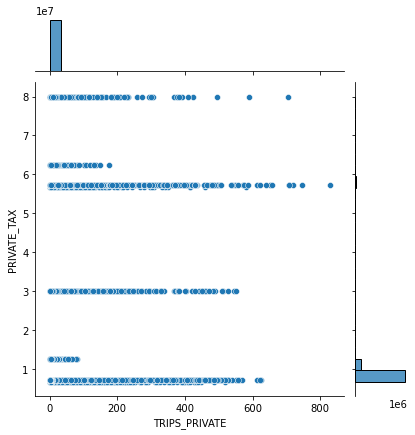

In [58]:
sns.jointplot(x = df['TRIPS_PRIVATE'], y = df['PRIVATE_TAX'])

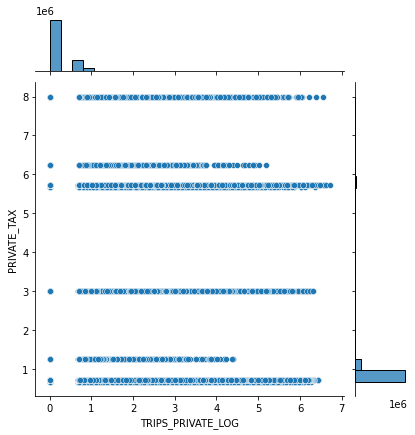

In [59]:
sns.jointplot(x = df['TRIPS_PRIVATE_LOG'], y = df['PRIVATE_TAX'])

In [ ]:
df

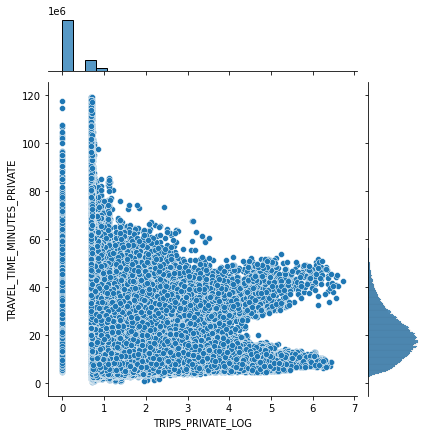

In [61]:
sns.jointplot(x = df['TRIPS_PRIVATE_LOG'], y = df['TRAVEL_TIME_MINUTES_PRIVATE'])

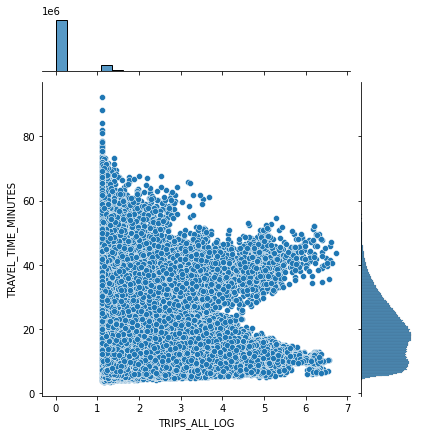

In [49]:
sns.jointplot(x = df['TRIPS_ALL_LOG'], y = df['TRAVEL_TIME_MINUTES'])

In [ ]:
sns.jointplot(x = df['TRIPS_ALL_EXP'], y = df['TRAVEL_TIME_MINUTES'])

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10265616 entries, ('17031010100.0_17031010100.0', Timestamp('2018-11-01 00:00:00')) to ('17031980100.0_17031980100.0', Timestamp('2020-02-01 00:00:00'))
Columns: 293 entries, Unnamed: 0 to TRIPS_SHARED_LOG
dtypes: float64(272), int32(4), int64(17)
memory usage: 22.3+ GB


In [69]:
no_zero = df[df['TRIPS_ALL']>0]

In [70]:
len(no_zero)

2979179

In [ ]:
sns.displot(df['TRIPS_ALL'])

In [ ]:
sns.histplot(df['TRIPS_ALL'])

In [77]:
no_zero['TRIPS_ALL_LOG'].min()

2.8999698408725185e-06

In [76]:
no_zero['TRIPS_ALL_LOG'].value_counts()

1.098612    3268
1.252763     361
1.203973     296
1.178655     284
1.386294     216
            ... 
1.429487       1
1.102564       1
1.108659       1
0.044795       1
0.049844       1
Name: TRIPS_ALL_LOG, Length: 2971109, dtype: int64

In [67]:
no_zero['TRIPS_ALL_LOG'] = np.log(no_zero['TRIPS_ALL'])

C:\Users\transportlab\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
no_zero[no_zero['TRIPS_ALL_LOG'] < 0]

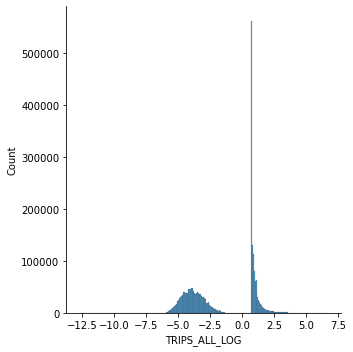

In [68]:
sns.displot(no_zero['TRIPS_ALL_LOG'])

In [15]:
#df= df[['ORIGIN','DESTINATION','MONTH','YEAR','TRIPS_SUPPRESSED','TRIPS_UNSUPPRESSED','TRAVEL_TIME_MINUTES','DISTANCE','FARE','TOTAL_POP','TOTAL_HHLDS','HHLDS_MEAN_INCOME','HHLDS_0_VEH','AVG_VEH_PER_HHLD','TOTAL_POP_DESTINATION','MEDIAN_AGE_DESTINATION','MEDIAN_AGE','TOTAL_HHLDS_DESTINATION','HHLDS_MEAN_INCOME_DESTINATION','HHLDS_0_VEH_DESTINATION','AVG_VEH_PER_HHLD_DESTINATION','travel_time','PRIVATE_TAX','SHARED_TAX','TOTAL_JOBS_ORIGIN','TOTAL_JOBS_DESTINATION','TOTAL_WORKERS_ORIGIN','TOTAL_WORKERS_DESTINATION']]

In [72]:
df3 = df[df['TRIPS_ALL']==0].groupby(by = ['ORIGIN','DESTINATION','MONTH','YEAR'], as_index = False).count()

In [73]:
df3.head()

,ORIGIN,DESTINATION,MONTH,YEAR,TRIPS_SUPPRESSED,TRIPS_UNSUPPRESSED,TRAVEL_TIME_MINUTES,DISTANCE,FARE,TOTAL_POP,MEDIAN_AGE,TOTAL_HHLDS,HHLDS_MEAN_INCOME,HHLDS_0_VEH,AVG_VEH_PER_HHLD,TOTAL_POP_DESTINATION,MEDIAN_AGE_DESTINATION,TOTAL_HHLDS_DESTINATION,HHLDS_MEAN_INCOME_DESTINATION,HHLDS_0_VEH_DESTINATION,AVG_VEH_PER_HHLD_DESTINATION,travel_time,PRIVATE_TAX,SHARED_TAX,TOTAL_JOBS_ORIGIN,TOTAL_JOBS_DESTINATION,TOTAL_WORKERS_ORIGIN,TOTAL_WORKERS_DESTINATION,TOTAL_WORKERS_OD,TOTAL_JOBS_OD,HHLDS_MEAN_INCOME_OD,AVG_VEH_PER_HHLD_OD,HHLDS_0_VEH_OD,MEDIAN_AGE_OD,TRIPS_ALL,TOTAL_POP_OD,TRIPS_ALL_EXP,TRIPS_ALL_LOG
0,1.703101e+10,1.703102e+10,4,2019,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1.703101e+10,1.703102e+10,8,2019,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1.703101e+10,1.703102e+10,4,2019,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1.703101e+10,1.703102e+10,11,2018,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1.703101e+10,1.703102e+10,12,2019,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [74]:
df3.groupby(by = ['ORIGIN','MONTH','YEAR'], as_index = False).count()

,ORIGIN,MONTH,YEAR,DESTINATION,TRIPS_SUPPRESSED,TRIPS_UNSUPPRESSED,TRAVEL_TIME_MINUTES,DISTANCE,FARE,TOTAL_POP,MEDIAN_AGE,TOTAL_HHLDS,HHLDS_MEAN_INCOME,HHLDS_0_VEH,AVG_VEH_PER_HHLD,TOTAL_POP_DESTINATION,MEDIAN_AGE_DESTINATION,TOTAL_HHLDS_DESTINATION,HHLDS_MEAN_INCOME_DESTINATION,HHLDS_0_VEH_DESTINATION,AVG_VEH_PER_HHLD_DESTINATION,travel_time,PRIVATE_TAX,SHARED_TAX,TOTAL_JOBS_ORIGIN,TOTAL_JOBS_DESTINATION,TOTAL_WORKERS_ORIGIN,TOTAL_WORKERS_DESTINATION,TOTAL_WORKERS_OD,TOTAL_JOBS_OD,HHLDS_MEAN_INCOME_OD,AVG_VEH_PER_HHLD_OD,HHLDS_0_VEH_OD,MEDIAN_AGE_OD,TRIPS_ALL,TOTAL_POP_OD,TRIPS_ALL_EXP,TRIPS_ALL_LOG
0,1.703101e+10,1,2019,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529
1,1.703101e+10,1,2020,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549,549
2,1.703101e+10,2,2019,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518
3,1.703101e+10,2,2020,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542
4,1.703101e+10,3,2019,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12811,1.703198e+10,10,2019,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
12812,1.703198e+10,11,2018,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
12813,1.703198e+10,11,2019,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135,135
12814,1.703198e+10,12,2018,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159


In [75]:
df3.groupby(by = ['DESTINATION','MONTH','YEAR'], as_index = False).count()

,DESTINATION,MONTH,YEAR,ORIGIN,TRIPS_SUPPRESSED,TRIPS_UNSUPPRESSED,TRAVEL_TIME_MINUTES,DISTANCE,FARE,TOTAL_POP,MEDIAN_AGE,TOTAL_HHLDS,HHLDS_MEAN_INCOME,HHLDS_0_VEH,AVG_VEH_PER_HHLD,TOTAL_POP_DESTINATION,MEDIAN_AGE_DESTINATION,TOTAL_HHLDS_DESTINATION,HHLDS_MEAN_INCOME_DESTINATION,HHLDS_0_VEH_DESTINATION,AVG_VEH_PER_HHLD_DESTINATION,travel_time,PRIVATE_TAX,SHARED_TAX,TOTAL_JOBS_ORIGIN,TOTAL_JOBS_DESTINATION,TOTAL_WORKERS_ORIGIN,TOTAL_WORKERS_DESTINATION,TOTAL_WORKERS_OD,TOTAL_JOBS_OD,HHLDS_MEAN_INCOME_OD,AVG_VEH_PER_HHLD_OD,HHLDS_0_VEH_OD,MEDIAN_AGE_OD,TRIPS_ALL,TOTAL_POP_OD,TRIPS_ALL_EXP,TRIPS_ALL_LOG
0,1.703101e+10,1,2019,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519
1,1.703101e+10,1,2020,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533,533
2,1.703101e+10,2,2019,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518,518
3,1.703101e+10,2,2020,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519,519
4,1.703101e+10,3,2019,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12811,1.703198e+10,10,2019,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97
12812,1.703198e+10,11,2018,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
12813,1.703198e+10,11,2019,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110,110
12814,1.703198e+10,12,2018,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129


In [62]:
len(df)

10265616

In [63]:
len(df[df['TRIPS_ALL']==0])

7286437

In [39]:
df[np.isnan(df['TRIPS_ALL'])][''].sum()

0.0

In [40]:
df[np.isnan(df['TRIPS_UNSUPPRESSED'])]['TRIPS_ALL'].sum()

0.0

In [44]:
df[df['TRIPS_ALL'] == 0]['TRIPS_SUPPRESSED'].sum()

49938.35425488895

In [46]:
df[df['TRIPS_ALL'] == 0]['TRIPS_UNSUPPRESSED'].sum()

62095.04947110383

In [55]:
df[(df['TRIPS_ALL'] == 0)&(df['TRIPS_UNSUPPRESSED']>0)]

,YEAR,MONTH,ORIGIN,DESTINATION,TRIPS_SUPPRESSED,TRIPS_UNSUPPRESSED,TRAVEL_TIME_MINUTES,DISTANCE,FARE,TOTAL_POP,MEDIAN_AGE,TOTAL_HHLDS,HHLDS_MEAN_INCOME,HHLDS_0_VEH,AVG_VEH_PER_HHLD,TOTAL_POP_DESTINATION,MEDIAN_AGE_DESTINATION,TOTAL_HHLDS_DESTINATION,HHLDS_MEAN_INCOME_DESTINATION,HHLDS_0_VEH_DESTINATION,AVG_VEH_PER_HHLD_DESTINATION,travel_time,PRIVATE_TAX,SHARED_TAX,TOTAL_JOBS_ORIGIN,TOTAL_JOBS_DESTINATION,TOTAL_WORKERS_ORIGIN,TOTAL_WORKERS_DESTINATION,TOTAL_WORKERS_OD,TOTAL_JOBS_OD,HHLDS_MEAN_INCOME_OD,AVG_VEH_PER_HHLD_OD,HHLDS_0_VEH_OD,MEDIAN_AGE_OD,TRIPS_ALL,TOTAL_POP_OD,TRIPS_ALL_EXP,TRIPS_ALL_LOG


In [54]:
df[(df['TRIPS_ALL'] == 0)&(df['TRIPS_SUPPRESSED']>0)]

,YEAR,MONTH,ORIGIN,DESTINATION,TRIPS_SUPPRESSED,TRIPS_UNSUPPRESSED,TRAVEL_TIME_MINUTES,DISTANCE,FARE,TOTAL_POP,MEDIAN_AGE,TOTAL_HHLDS,HHLDS_MEAN_INCOME,HHLDS_0_VEH,AVG_VEH_PER_HHLD,TOTAL_POP_DESTINATION,MEDIAN_AGE_DESTINATION,TOTAL_HHLDS_DESTINATION,HHLDS_MEAN_INCOME_DESTINATION,HHLDS_0_VEH_DESTINATION,AVG_VEH_PER_HHLD_DESTINATION,travel_time,PRIVATE_TAX,SHARED_TAX,TOTAL_JOBS_ORIGIN,TOTAL_JOBS_DESTINATION,TOTAL_WORKERS_ORIGIN,TOTAL_WORKERS_DESTINATION,TOTAL_WORKERS_OD,TOTAL_JOBS_OD,HHLDS_MEAN_INCOME_OD,AVG_VEH_PER_HHLD_OD,HHLDS_0_VEH_OD,MEDIAN_AGE_OD,TRIPS_ALL,TOTAL_POP_OD,TRIPS_ALL_EXP,TRIPS_ALL_LOG


In [ ]:
df3 = pd.DataFrame()